In [40]:
from qiskit import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
pi = np.pi
import pyscf
from qiskit_nature.second_q.drivers import PySCFDriver
import qiskit_nature.units as units
import qiskit_nature.second_q as sq

In [41]:
# Initialize Molecule
driver = PySCFDriver(
        atom ='H 0 0 0; H 0 0 {}'.format(1.401),
        unit = units.DistanceUnit.BOHR,
        charge = 0,
        spin = 0,
        basis="sto3g"
    )
hydrogen = driver.run()

# Get Hamiltonian and convert it to second quantized form
hamiltonian = hydrogen.hamiltonian
sq_form = hamiltonian.second_q_op()
repulsion = hamiltonian.nuclear_repulsion_energy

# Map SQ Hamiltonian onto Pauli matrices and store the necessary prefactors in a dictionary
BKconverter = sq.mappers.QubitConverter(sq.mappers.BravyiKitaevMapper())
JWconverter = sq.mappers.QubitConverter(sq.mappers.JordanWignerMapper())
BKHam = BKconverter.convert(sq_form)
JWHam = JWconverter.convert(sq_form)
coeffsBK = dict((x, np.real(y)) for x, y in BKHam.primitive.to_list())
coeffsJW = dict((x, np.real(y)) for x, y in JWHam.primitive.to_list())

# initialize the samplingrate (inverse trotter step size)
sampling_rate = 20
# points in time, at which U is simulated
t = np.arange(0, 1, 1/sampling_rate)
n = len(t)

# initialize Quantum Circuit
qr = QuantumRegister(4)
qc = QuantumCircuit(qr)

#Bravyi-Kitaev Hamiltonian one Trotter step

#IIII
qc.p(-2*pi*coeffsBK['IIII']/sampling_rate, qr[0])
qc.x(qr[0])
qc.p(-2*pi*coeffsBK['IIII']/sampling_rate, qr[0])
qc.x(qr[0])

#IIIZ
qc.rz(2*2*pi*coeffsBK['IIIZ']/sampling_rate, qr[0])

#IIZI
qc.rz(2*pi*2*coeffsBK['IIZI']/sampling_rate, qr[1])

#IZII
qc.rz(2*pi*2*coeffsBK['IZII']/sampling_rate, qr[2])

#ZZZI
qc.cx(qr[3], qr[1])
qc.cx(qr[1], qr[2])
qc.rz(2*pi*2*coeffsBK['ZZZI']/sampling_rate, qr[2])
qc.cx(qr[1], qr[2])

#ZIZI
qc.rz(2*pi*2*coeffsBK['ZIZI']/sampling_rate, qr[1])
qc.cx(qr[3], qr[1])

#ZZIZ
qc.cx(qr[2], qr[0])
qc.cx(qr[0], qr[3])
qc.rz(2*pi*2*coeffsBK['ZZIZ']/sampling_rate, qr[3])
qc.cx(qr[0], qr[3])

#IZIZ
qc.rz(2*pi*2*coeffsBK['IZIZ']/sampling_rate, qr[0])
qc.cx(qr[2], qr[0])

#ZZZZ
qc.cx(qr[0], qr[1])
qc.cx(qr[1], qr[2])
qc.cx(qr[2], qr[3])
qc.rz(2*pi*2*coeffsBK['ZZZZ']/sampling_rate, qr[3])
qc.cx(qr[2], qr[3])

#IZZZ
qc.rz(2*pi*2*coeffsBK['IZZZ']/sampling_rate, qr[2])
qc.cx(qr[1], qr[2])

#IIZZ
qc.rz(2*pi*2*coeffsBK['IIZZ']/sampling_rate, qr[1])
qc.cx(qr[0], qr[1])

#ZXIX
qc.h(qr[2])
qc.h(qr[0])
qc.cx(qr[0], qr[2])
qc.cx(qr[2], qr[3])
qc.rz(2*pi*2*coeffsBK['ZXIX']/sampling_rate, qr[3])
qc.cx(qr[2], qr[3])

#IXZX
qc.cx(qr[2], qr[1])
qc.rz(2*pi*2*coeffsBK['IXZX']/sampling_rate, qr[1])

#ZXZX
qc.cx(qr[1], qr[3])
qc.rz(2*2*pi*coeffsBK['ZXZX']/sampling_rate, qr[3])
qc.cx(qr[1], qr[3])
qc.cx(qr[2], qr[1])

#IXIX
qc.rz(2*pi*2*coeffsBK['IXIX']/sampling_rate, qr[2])
qc.cx(qr[0], qr[2])
qc.h(qr[2])
qc.h(qr[0])

cUBK = qc.to_gate().control(1)
qc.clear()

# Jordan Wigner Hamiltonian one trotter step JW

#IIII
qc.p(-2*pi*coeffsJW['IIII']/sampling_rate, qr[0])
qc.x(qr[0])
qc.p(-2*pi*coeffsJW['IIII']/sampling_rate, qr[0])
qc.x(qr[0])

#IIIZ
qc.rz(2*pi*2*coeffsJW['IIIZ']/sampling_rate, qr[0])

#IIZI
qc.rz(2*pi*2*coeffsJW['IIZI']/sampling_rate, qr[1])

#IZII
qc.rz(2*pi*2*coeffsJW['IZII']/sampling_rate, qr[2])

#ZIII
qc.rz(2*pi*2*coeffsJW['ZIII']/sampling_rate, qr[3])

#IIZZ
qc.cx(qr[1], qr[0])
qc.rz(2*pi*2*coeffsJW['IIZZ']/sampling_rate, qr[0])
qc.cx(qr[1], qr[0])

#IZIZ
qc.cx(qr[2], qr[0])
qc.rz(2*pi*2*coeffsJW['IZIZ']/sampling_rate, qr[0])
qc.cx(qr[2], qr[0])

#ZIIZ
qc.cx(qr[3], qr[0])
qc.rz(2*pi*2*coeffsJW['ZIIZ']/sampling_rate, qr[0])
qc.cx(qr[3], qr[0])

#IZZI
qc.cx(qr[2], qr[1])
qc.rz(2*pi*2*coeffsJW['IZZI']/sampling_rate, qr[1])
qc.cx(qr[2], qr[1])

#ZIZI
qc.cx(qr[3], qr[1])
qc.rz(2*pi*2*coeffsJW['ZIZI']/sampling_rate, qr[1])
qc.cx(qr[3], qr[1])

#ZZII
qc.cx(qr[3], qr[2])
qc.rz(2*pi*2*coeffsJW['ZZII']/sampling_rate, qr[2])
qc.cx(qr[3], qr[2])

#YYYY
qc.rx(-pi/2, qr[0])
qc.rx(-pi/2, qr[1])
qc.rx(-pi/2, qr[2])
qc.rx(-pi/2, qr[3])
qc.cx(qr[3], qr[2])
qc.cx(qr[2], qr[1])
qc.cx(qr[1], qr[0])
qc.rz(2*pi*2*coeffsJW['YYYY']/sampling_rate, qr[0])
qc.cx(qr[1], qr[0])
qc.cx(qr[2], qr[1])
qc.cx(qr[3], qr[2])
qc.rx(pi/2, qr[0])
qc.rx(pi/2, qr[1])
qc.rx(pi/2, qr[2])
qc.rx(pi/2, qr[3])

#XXXX
qc.h(qr[0])
qc.h(qr[1])
qc.h(qr[2])
qc.h(qr[3])
qc.cx(qr[3], qr[2])
qc.cx(qr[2], qr[1])
qc.cx(qr[1], qr[0])
qc.rz(2*pi*2*coeffsJW['XXXX']/sampling_rate, qr[0])
qc.cx(qr[1], qr[0])
qc.cx(qr[2], qr[1])
qc.cx(qr[3], qr[2])
qc.h(qr[0])
qc.h(qr[1])
qc.h(qr[2])
qc.h(qr[3])

#XXYY
qc.h(qr[3])
qc.h(qr[2])
qc.rx(-pi/2, qr[1])
qc.rx(-pi/2, qr[0])
qc.cx(qr[3], qr[2])
qc.cx(qr[2], qr[1])
qc.cx(qr[1], qr[0])
qc.rz(2*pi*2*coeffsJW['XXYY']/sampling_rate, qr[0])
qc.cx(qr[1], qr[0])
qc.cx(qr[2], qr[1])
qc.cx(qr[3], qr[2])
qc.h(qr[3])
qc.h(qr[2])
qc.rx(pi/2, qr[1])
qc.rx(pi/2, qr[0])

#YYXX
qc.rx(-pi/2, qr[3])
qc.rx(-pi/2, qr[2])
qc.h(qr[1])
qc.h(qr[0])
qc.cx(qr[3], qr[2])
qc.cx(qr[2], qr[1])
qc.cx(qr[1], qr[0])
qc.rz(2*pi*2*coeffsJW['YYXX']/sampling_rate, qr[0])
qc.cx(qr[1], qr[0])
qc.cx(qr[2], qr[1])
qc.cx(qr[3], qr[2])
qc.rx(pi/2, qr[3])
qc.rx(pi/2, qr[2])
qc.h(qr[1])
qc.h(qr[0])

cUJW = qc.to_gate().control(1)
qc.clear()

# initialize new circuit and  simulator
shots = 10000
qreg = QuantumRegister(5)
creg = ClassicalRegister(1)
circ = QuantumCircuit(qreg, creg)
simulator = Aer.get_backend('aer_simulator')

# Arrays, that store the value of U at time t
time_evolution_BK = np.zeros(n)
time_evolution_JW = np.zeros(n)

-1.136824125624554

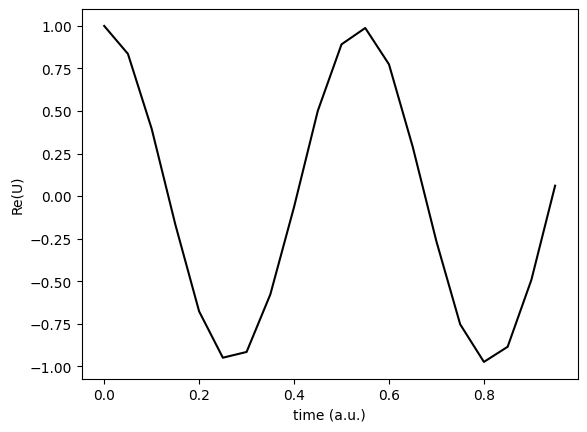

In [23]:
# simulate BK Hamiltonian for real part of U, t fixed, Trotter steps increasing
for i in range(n):
    # set the initial state
    circ.x(qreg[0])
    circ.x(qreg[1])
    circ.x(qreg[2])
    #circ.x(qreg[3])
    
    #perform Hadamard test
    circ.h(qreg[4])
    for _ in range(i):
        circ.append(cUBK, [4, 0, 1, 2, 3])
    circ.h(qreg[4])
    circ.measure(qreg[4], creg[0])
    
    # Simulate the circuit classically and evaluate the results
    circ = transpile(circ, simulator)
    result = simulator.run(circ, shots=shots).result()
    counts = result.get_counts(0)
    if '1' in counts and '0' in counts:
        time_evolution_BK[i] = (counts['0'] - counts['1']) / shots
    elif '1' in counts:
        time_evolution_BK[i] = -1
    else:
        time_evolution_BK[i] = 1
    circ.clear()

# Fourier analysis of the BK time evolution, to obtain frequencies and thus eigenenergies
fourier_BK = np.abs(fft(time_evolution_BK, n=10000*len(t)))
N = len(fourier_BK)
freqs_BK = fftfreq(N, 1/sampling_rate)
peak_index_BK = find_peaks(fourier_BK, height=4)[0]

# Ground state energy calculated by FFT algorithm for BK time evolution
energy_BK = -freqs_BK[peak_index_BK[0]] + repulsion

# Plot of the time evolution
plt.plot(t, time_evolution_BK, 'k-')
plt.xlabel('time (a.u.)')
plt.ylabel('Re(U)')

-1.138024125624554

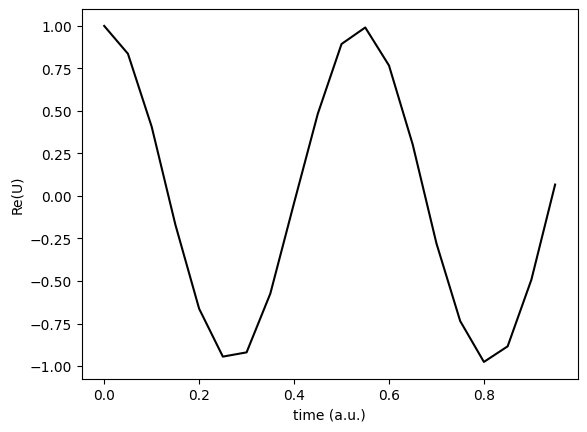

In [24]:
# simulate JW Hamiltonian for real part of U, t fixed, Trotter steps increasing
for i in range(n):
    # set the initial state
    circ.x(qreg[0])
    #circ.x(qreg[1])
    circ.x(qreg[2])
    #circ.x(qreg[3])

    #perform Hadamard test
    circ.h(qreg[4])
    for _ in range(i):
        circ.append(cUJW, [4, 0, 1, 2, 3])
    circ.h(qreg[4])
    circ.measure(qreg[4], creg[0])

    # simulate the circuit classically and evaluate the results
    circ = transpile(circ, simulator)
    result = simulator.run(circ, shots=shots).result()
    counts = result.get_counts(0)
    if '1' in counts and '0' in counts:
        time_evolution_JW[i] = (counts['0'] - counts['1']) / shots
    elif '1' in counts:
        time_evolution_JW[i] = -1
    else:
        time_evolution_JW[i] = 1
    circ.clear()

# Perform Fourier Analysis for the real part of U
fourier_JW = np.abs(fft(time_evolution_JW, n=10000*len(t)))
N = len(fourier_JW)
freqs_JW = fftfreq(N, 1/sampling_rate)
peak_index_JW = find_peaks(fourier_JW, height=4)[0]

# Ground state energy calculated by FFT algorithm for BK time evolution
energy_JW = -freqs_JW[peak_index_JW[0]] + repulsion

# Plot of the time evolution
plt.plot(t, time_evolution_JW, 'k-')
plt.xlabel('time (a.u.)')
plt.ylabel('Re(U)')